<img src="https://drive.google.com/uc?export=view&id=1x-QAgitB-S5rxGGDqxsJ299ZQTfYtOhb" width=180, align="center"/>

Master's degree in Intelligent Systems

Subject: 11772 - TFM

Year: 2023-2024

Lyes Boudia

## Set up

In [ ]:
pip install piqa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Import libraries
import os
from imutils import paths
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from piqa import MS_SSIM
from torchvision.transforms.functional import to_tensor
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
import albumentations as A
import time
import copy
from collections import defaultdict
from torchsummary import summary
import glob
import re
import random

In [4]:
# Global variables and parameters
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

# Parameters
NUM_CLASS = 3  # Number of different classes to segmentate
batch_size = 1  # Batch size

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {str(DEVICE)}")

# Number of pixels of square images. If images are bigger (and they are)
# you will need to adjust the size at the transformations doing a crop
#IM_SIZE = 224

# Proportion of validation and test dataset sizes
VALID_SIZE = 0.1
TEST_SIZE = 0.1

Using cpu


## First steps

In [ ]:
PROJECT_DIR = '/teamspace/studios/this_studio/'
ds = ''  # relative path from PROJECT_DIR
#Define the paths to the dataset 
RAW_PATH = os.path.join(PROJECT_DIR, ds + 'raw')
REF_PATH = os.path.join(PROJECT_DIR, ds + 'ref')
CON_PATH = os.path.join(PROJECT_DIR, ds + 'con')
#show the paths
print(RAW_PATH)
print(REF_PATH)

/teamspace/studios/this_studio/raw
/teamspace/studios/this_studio/ref


In [ ]:
#we have sorted the list of raw image paths and the list of corresponding reference paths and classifier prediction image paths
raw_paths = sorted(list(paths.list_images(RAW_PATH)))
print(raw_paths[:10])
ref_paths = sorted(list(paths.list_images(REF_PATH)))
print(ref_paths[:10])
con_paths = sorted(list(paths.list_images(CON_PATH)))

['/teamspace/studios/this_studio/raw/100_img_.png', '/teamspace/studios/this_studio/raw/10139.png', '/teamspace/studios/this_studio/raw/10151.png', '/teamspace/studios/this_studio/raw/101_img_.png', '/teamspace/studios/this_studio/raw/102_img_.png', '/teamspace/studios/this_studio/raw/104_img_.png', '/teamspace/studios/this_studio/raw/105_img_.png', '/teamspace/studios/this_studio/raw/106_img_.png', '/teamspace/studios/this_studio/raw/107_img_.png', '/teamspace/studios/this_studio/raw/108_img_.png']
['/teamspace/studios/this_studio/ref/100_img_.png', '/teamspace/studios/this_studio/ref/10139.png', '/teamspace/studios/this_studio/ref/10151.png', '/teamspace/studios/this_studio/ref/101_img_.png', '/teamspace/studios/this_studio/ref/102_img_.png', '/teamspace/studios/this_studio/ref/104_img_.png', '/teamspace/studios/this_studio/ref/105_img_.png', '/teamspace/studios/this_studio/ref/106_img_.png', '/teamspace/studios/this_studio/ref/107_img_.png', '/teamspace/studios/this_studio/ref/108_i

In [ ]:
# Check if lists are ok

assert len(raw_paths) > 0, "ERROR - Void list!!"

assert len(raw_paths) == len (ref_paths), "ERROR - Lists with different length"

for k in range(len(raw_paths)):
    imname = os.path.basename(raw_paths[k]).split('.')[0]
    mkname = os.path.basename(ref_paths[k]).split('.')[0]
    if imname != mkname:
        raise TypeError(f"ERROR - Names inconsistent. raw: ({imname}) reference: {mkname}")

Now that we have the list of paths, let's see an image with its reference

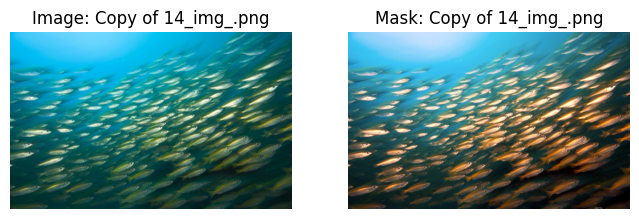

In [ ]:
# Load the image and mask number n
n = 2

# Load the image and mask using PIL
raw = Image.open(raw_paths[n])
ref = Image.open(ref_paths[n])

# Show the image and mask using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(raw)
axs[0].axis('off')
axs[0].set_title(f'Image: {os.path.basename(raw_paths[n])}')
axs[1].imshow(ref)
axs[1].axis('off')
axs[1].set_title(f'Mask: {os.path.basename(ref_paths[n])}')
plt.show()

## Train, validation and test

In [ ]:
random.seed(42)

num_samples = len(raw_paths)
num_valid = int(num_samples * VALID_SIZE)
num_train = num_samples - num_valid

# Create shuffled indices
random_indices = list(range(num_samples))
random.shuffle(random_indices)

#random_indices = random.sample(range(num_samples), num_samples)
raw_paths = [raw_paths[i] for i in random_indices]
ref_paths = [ref_paths[i] for i in random_indices]
con_paths = [con_paths[i] for i in random_indices]

raw_train_paths = raw_paths[:num_train]
ref_train_paths = ref_paths[:num_train]
con_train_paths = con_paths[:num_train]

print('raw train list ',raw_train_paths)
print('ref train list',ref_train_paths)

print()
print()

# Validation paths
raw_valid_paths = raw_paths[num_train:num_train+num_valid]
ref_valid_paths = ref_paths[num_train:num_train+num_valid]
con_valid_paths = con_paths[num_train:num_train+num_valid]
print('raw validation list ',raw_valid_paths)
print('ref validation list ',ref_valid_paths)
print()
print()

## The dataset class

In [ ]:
class UnderwaterEnhancementDataset(Dataset):
    def __init__(self, raw_paths, ref_paths, con_paths, transformations=None, min_size=3, num_blocks=9):
        self.raw_paths = raw_paths
        self.ref_paths = ref_paths
        self.con_paths = con_paths
        self.transforms = transformations
        self.min_size = min_size
        self.num_blocks = num_blocks

    def __len__(self):
        return len(self.raw_paths)

    def _calculate_stop_level(self, dimension):
        level = 0
        while dimension > self.min_size:
            if dimension // 2 < self.min_size:
                break  # Stop further downsampling
            dimension = dimension // 2
            level += 1
        return level

    def __getitem__(self, idx):
        # Load images
        raw_path = self.raw_paths[idx]
        raw = Image.open(raw_path)
        raw = (np.clip(np.asarray(raw, dtype=np.float32), 0, 255) / 255.0).astype(np.float32)

        ref_path = self.ref_paths[idx]
        ref = Image.open(ref_path)
        ref = (np.clip(np.asarray(ref, dtype=np.float32), 0, 255) / 255.0).astype(np.float32)


        con_path = self.con_paths[idx]
        con = Image.open(con_path)
        con = (np.clip(np.asarray(con, dtype=np.float32), 0, 255) / 255.0).astype(np.float32)

        # Calculate the stopping levels for downsampling
        raw_height, raw_width = raw.shape[:2]
        stop_level_h = self._calculate_stop_level(raw_height)
        stop_level_w = self._calculate_stop_level(raw_width)

        # Determine the stride values for downsampling/upsampling
        stride_h = [2 if i < stop_level_h else 1 for i in range(self.num_blocks)]
        stride_w = [2 if i < stop_level_w else 1 for i in range(self.num_blocks)]

        # Determine the downsampling flag
        downsampling_flag = [True if i < max(stop_level_h, stop_level_w) else False for i in range(self.num_blocks)]
        start_level = max(stop_level_h, stop_level_w)

        # Apply albumentations transforms if any
        if self.transforms:
            transformed = self.transforms(image=raw, mask=ref)
            raw = transformed['image']
            ref = transformed['mask']

        # Return the image, reference, stride values, and downsampling flag
        return (to_tensor(raw), to_tensor(ref), to_tensor(con), stride_h, stride_w, downsampling_flag, start_level)

In [9]:
class RandomFixedRotation(A.DualTransform):
    """Albumentations-compatible transform for random fixed rotations."""
    def __init__(self, angles, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.angles = angles

    def apply(self, img, **params):
        angle = params['angle']
        pil_img = Image.fromarray(img)
        rotated_img = pil_img.rotate(angle)
        return np.array(rotated_img)

    def apply_to_mask(self, mask, **params):
        angle = params['angle']
        pil_mask = Image.fromarray(mask)
        rotated_mask = pil_mask.rotate(angle)
        return np.array(rotated_mask)

    def get_params(self):
        return {'angle': random.choice(self.angles)}

In [ ]:
# Define transforms for train dataset
transform_train = A.Compose([
    RandomFixedRotation(angles=[0, 90, 180, 270], p=1.0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3)
])
# Define transforms for test dataset
transform_test = A.Compose([
    # Apply horizontal flips with a probability of 0.5
    # A.HorizontalFlip(p=0.5),
    # Normalize the image by dividing each pixel value by 255
    #A.Normalize(),
])

Define the datasets

In [40]:
# Define the three basic datasets
valid_set = UnderwaterEnhancementDataset(raw_train_paths,
                       ref_train_paths,
                       con_train_paths,
                       transform_test
                       )

train_set = UnderwaterEnhancementDataset(raw_valid_paths,
                       ref_valid_paths,
                       con_valid_paths,
                       transform_test)

# test_set = UnderwaterEnhancementDataset(raw_test_paths,
#                       ref_test_paths,
#                       transform_test)

datasets = {'train': train_set, 'valid': valid_set} #, 'test': test_set}

And now define the dataloaders

In [ ]:
num_workers = 4
shuffle = True
tbs = 1  # Test batch size
dataloaders = {'train': DataLoader(train_set,
                                   batch_size=batch_size,
                                   shuffle=shuffle,
                                   num_workers=num_workers),
               'valid': DataLoader(valid_set,
                                   batch_size=batch_size,
                                   shuffle=shuffle,
                                   num_workers=num_workers)}
              #  'test': DataLoader(test_set,
              #                     batch_size=tbs,
              #                     shuffle=False,
              #                     num_workers=num_workers)}

In [42]:
def to_npimage(tensor_im):
    # From tensor with shape (C x H x W) to numpy with shape (H x W x C)
    return tensor_im.numpy().transpose((1, 2, 0))

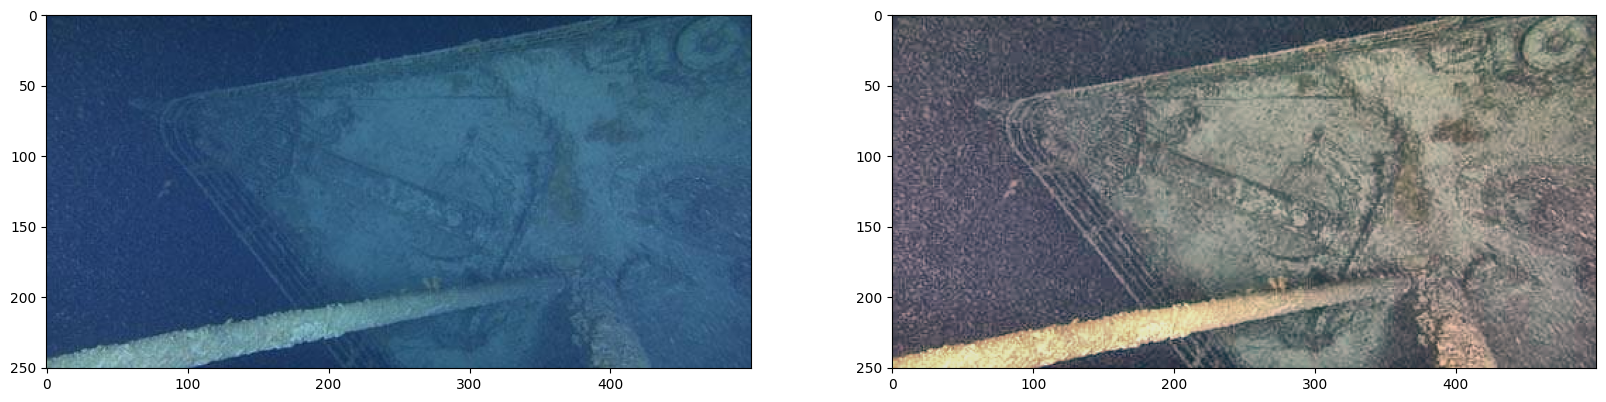

In [14]:
# Get a batch of training data
inputs, ref , con, stride_h, stride_w, downsampling_flag, start_level = next(iter(dataloaders['train']))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Convert tensor image into numpy and display it in the first subplot
raw = to_npimage(inputs[0])
axs[0].imshow(raw)

# Convert tensor mask into numpy and display it in the second subplot
ref = to_npimage(ref[0])
axs[1].imshow(ref)

# Show the figure
plt.show()

In [15]:
class CustomBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomBlock, self).__init__()

        # Shared weights for the first BasicBlock
        self.conv1_1 = {
            (2,2): nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
            (1,2): nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=(1, 2), padding=1, bias=False),
            (2,1): nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=(2,1), padding=1, bias=False)
        }

        self.bn1_1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1_2 = nn.BatchNorm2d(out_channels)

        # Downsampling layers for different stride configurations
        self.downsample_layers = {
            (2, 2): nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(out_channels)
            ),
            (1, 2): nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(1, 2), bias=False),
                nn.BatchNorm2d(out_channels)
            ),
            (2, 1): nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(2, 1), bias=False),
                nn.BatchNorm2d(out_channels)
            ),
        }

        # Shared weights for the second BasicBlock
        self.conv2_1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2_1 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2_2 = nn.BatchNorm2d(out_channels)

    def forward(self, x, stride_h, stride_w):
        residual = x

        # First BasicBlock
        x = self.conv1_1[(stride_h.item(), stride_w.item())](x)
        x = self.bn1_1(x)
        x = self.relu1(x)
        x = self.conv1_2(x)
        x = self.bn1_2(x)

        # Downsampling
        residual = self.downsample_layers[(stride_h.item(), stride_w.item())](residual)

        # Add residual and activate
        x += residual
        x = self.relu1(x)

        # Second BasicBlock
        residual = x
        x = self.conv2_1(x)
        x = self.bn2_1(x)
        x = self.relu2(x)
        x = self.conv2_2(x)
        x = self.bn2_2(x)

        # Add residual and activate
        x += residual
        x = self.relu2(x)

        return x

In [16]:
class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        def convrelu(in_channels, out_channels, kernel, padding):
            return nn.Sequential(nn.Conv2d(in_channels,
                                           out_channels,
                                           kernel,
                                           padding=padding),
                                 nn.ReLU(inplace=True))

        # Base model
        self.base_model = models.resnet18(weights='DEFAULT')
        self.base_layers = list(self.base_model.children())

        # Forward pass of the first part of the base model
        self.step1 = nn.Sequential(*self.base_layers[:3])
        self.step2 = nn.Sequential(*self.base_layers[3:5])
        self.step3 = self.base_layers[5]
        self.step4 = self.base_layers[6]
        self.step5 = self.base_layers[7]
        self.step6 = CustomBlock(512, 512)
        self.step7 = CustomBlock(512, 512)
        self.step8 = CustomBlock(512, 512)
        self.step9 = CustomBlock(512, 512)

        # Skip pathways (from encoder steps through decoder steps)
        self.skip0 = nn.Sequential(convrelu(3, 64, 3, 1),
                                   convrelu(64, 64, 3, 1))
        self.skip1 = convrelu(64, 64, 1, 0)
        self.skip2 = convrelu(64, 64, 1, 0)
        self.skip3 = convrelu(128, 128, 1, 0)
        self.skip4 = convrelu(256, 256, 1, 0)
        self.skip5 = convrelu(512, 512, 1, 0)
        self.skip6 = convrelu(512, 512, 1, 0)
        self.skip7 = convrelu(512, 512, 1, 0)
        self.skip8 = convrelu(512, 512, 1, 0)
        self.skip9 = convrelu(512, 512, 1, 0)

        # Upsample to the upper level
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Dimensional adaptation during decoder part (skips + upsamples)
        self.adapt8 = convrelu(512 + 512, 512, 3, 1)
        self.adapt7 = convrelu(512 + 512, 512, 3, 1)
        self.adapt6 = convrelu(512 + 512, 512, 3, 1)
        self.adapt5 = convrelu(512 + 512, 512, 3, 1)
        self.adapt4 = convrelu(256 + 512, 512, 3, 1)
        self.adapt3 = convrelu(128 + 256, 256, 3, 1)
        self.adapt2 = convrelu(64 + 128, 256, 3, 1)
        self.adapt1 = convrelu(64 + 64, 128, 3, 1)
        self.adapt0 = convrelu(64 + 64, 64, 3, 1)

        # Adaptation to mask classes
        self.mask_classes = nn.Conv2d(64, n_class, 1)

    def forward(self, input, stride_h, stride_w, downsampling_flag, start_level):

        # Encoder outputs

        level1 = self.step1(input)
        level2 = self.step2(level1)
        level3 = self.step3(level2)
        level4 = self.step4(level3)
        level5 = self.step5(level4)

        # Applying CustomBlock only if downsampling_flag is True
        level6 = self.step6(level5, stride_h[5], stride_w[5]) if downsampling_flag[5].item() else None
        level7 = self.step7(level6, stride_h[6], stride_w[6]) if downsampling_flag[6].item() else None
        level8 = self.step8(level7, stride_h[7], stride_w[7]) if downsampling_flag[7].item() else None
        level9 = self.step9(level8, stride_h[8], stride_w[8]) if downsampling_flag[8].item() else None

        # Skip connections
        level0 = self.skip0(input)
        level1 = self.skip1(level1)
        level2 = self.skip2(level2)
        level3 = self.skip3(level3)
        level4 = self.skip4(level4)
        level5 = self.skip5(level5)
        level6 = self.skip6(level6) if downsampling_flag[5].item() else None
        level7 = self.skip7(level7) if downsampling_flag[6].item() else None
        level8 = self.skip8(level8) if downsampling_flag[7].item() else None
        level9 = self.skip9(level9) if downsampling_flag[8].item() else None

    # Decoder path
        if downsampling_flag[8].item():
            x = self.upsample(level9)
            if x.shape[2] != level8.shape[2] or x.shape[3] != level8.shape[3]:
                x = x[:, :, :level8.shape[2], :level8.shape[3]]
            x = torch.cat([x, level8], dim=1)
            x = self.adapt8(x)

        if downsampling_flag[7].item():
            x = self.upsample(level8)
            if x.shape[2] != level7.shape[2] or x.shape[3] != level7.shape[3]:
                x = x[:, :, :level7.shape[2], :level7.shape[3]]
            x = torch.cat([x, level7], dim=1)
            x = self.adapt7(x)

        if downsampling_flag[6].item():
            x = self.upsample(level7)
            if x.shape[2] != level6.shape[2] or x.shape[3] != level6.shape[3]:
                x = x[:, :, :level6.shape[2], :level6.shape[3]]
            x = torch.cat([x, level6], dim=1)
            x = self.adapt6(x)

        if downsampling_flag[5].item():
            x = self.upsample(level6)
            if x.shape[2] != level5.shape[2] or x.shape[3] != level5.shape[3]:
                x = x[:, :, :level5.shape[2], :level5.shape[3]]
            x = torch.cat([x, level5], dim=1)
            x = self.adapt5(x)

        x = self.upsample(level5)
        if x.shape[2] != level4.shape[2] or x.shape[3] != level4.shape[3]:
            x = x[:, :, :level4.shape[2], :level4.shape[3]]
        x = torch.cat([x, level4], dim=1)
        x = self.adapt4(x)

        x = self.upsample(level4)
        if x.shape[2] != level3.shape[2] or x.shape[3] != level3.shape[3]:
            x = x[:, :, :level3.shape[2], :level3.shape[3]]
        x = torch.cat([x, level3], dim=1)
        x = self.adapt3(x)

        x = self.upsample(level3)
        if x.shape[2] != level2.shape[2] or x.shape[3] != level2.shape[3]:
            x = x[:, :, :level2.shape[2], :level2.shape[3]]
        x = torch.cat([x, level2], dim=1)
        x = self.adapt2(x)

        x = self.upsample(level2)
        if x.shape[2] != level1.shape[2] or x.shape[3] != level1.shape[3]:
            x = x[:, :, :level1.shape[2], :level1.shape[3]]
        x = torch.cat([x, level1], dim=1)
        x = self.adapt1(x)

        x = self.upsample(level1)
        if x.shape[2] != level0.shape[2] or x.shape[3] != level0.shape[3]:
            x = x[:, :, :level0.shape[2], :level0.shape[3]]
        x = torch.cat([x, level0], dim=1)
        x = self.adapt0(x)

        # Final output
        out = self.mask_classes(x)
        out = torch.sigmoid(out)

        return out

## Helper functions

In [ ]:
def select_model(option=1, num_class=3):

    if option == 1:
        arch = "ResNetUnet"
        encoder_name = ""
        encoder_weights = None
        in_channels = 3
        out_channels = num_class

        model = ResNetUNet(NUM_CLASS).to(DEVICE)

        optimizer = optim.Adam(filter(lambda param: param.requires_grad,
                                      model.parameters()), lr=0.001)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    return model, arch, encoder_name, optimizer, scheduler

In [ ]:
###############################################################################
# Function: save_tr_model
###############################################################################

def save_tr_model(model, optimizer, scheduler, training_log,
                  filename='model.pth', *args, **kwargs):
    model.to('cpu')
    custom_dict = {'model_state_dict': model.state_dict(),
                   'opt_state_dict': optimizer.state_dict(),
                   'sche_state_dict': scheduler.state_dict(),
                   'training_log': training_log,
                   'time': time.localtime()}

    torch.save(custom_dict, filename)
    model.to(DEVICE)

In [19]:
# Initialize MS-SSIM loss
msssim_loss_fn = MS_SSIM().to(DEVICE)
def loss_fcn(pred, target, metrics, mode='train'):

    pred = pred.contiguous()
    target = target.contiguous()

    # 1. Calculate standard losses (60% total)
    msssim_loss = 1 - msssim_loss_fn(pred, target)
    l1_loss = F.l1_loss(pred, target)

    total_loss = 0.8*msssim_loss + 0.2*l1_loss

    # Update metrics
    metrics[mode + '_msssim_loss'] += msssim_loss.detach().cpu().numpy() * target.size(0)
    metrics[mode + '_l1'] += l1_loss.detach().cpu().numpy() * target.size(0)
    metrics[mode + '_loss'] += total_loss.detach().cpu().numpy() * target.size(0)
    metrics[mode + '_epoch_samples'] += target.size(0)

    return total_loss, metrics

In [20]:
###############################################################################
# Function: update_metrics
###############################################################################

def update_metrics(metrics):
    # Get the number os samples of train and validation or test
    train_epoch_samples = metrics['train_epoch_samples']
    valid_epoch_samples = metrics['valid_epoch_samples']
    test_epoch_samples = metrics['test_epoch_samples']

    # Delete these data from the metrics dictionary
    metrics.pop('train_epoch_samples')
    metrics.pop('valid_epoch_samples')
    metrics.pop('test_epoch_samples')

    # Calculate the average metrics of all the batches; i.e. the epoch metrics
    for m in metrics.keys():
        if m.startswith('train'):
            metrics[m] /= train_epoch_samples
        elif m.startswith('valid'):
            metrics[m] /= valid_epoch_samples
        elif m.startswith('test'):
            metrics[m] /= test_epoch_samples

    return metrics

In [21]:
###############################################################################
# Function: print_metrics
###############################################################################

def print_metrics(metrics, minimum=False):
    outputs = []

    if minimum:
        outputs.append("Tr loss: {:.4f} - Val loss: {:.4f} - Time: {:.1f}".format(
            metrics['train_loss'], metrics['valid_loss'], metrics['time']))
    else:
        for m in metrics.keys():
            outputs.append("{}: {:.4f}".format(m, metrics[m]))

    print("Epoch summary: {}".format(" - ".join(outputs)))

In [ ]:
def train_model(model, optimizer, scheduler, loaders, num_epochs=10, checkpoint=None, verbose=0):
    # Load training progress if checkpoint exists
    if checkpoint:
        training_log = checkpoint['training_log']
        train_loss_min = np.min([x['train_loss'] for x in training_log])
        trained_epochs = len(training_log)
        best_state_dict = copy.deepcopy(model.state_dict())
    else:
        training_log = []
        train_loss_min = np.inf
        trained_epochs = 0
        best_state_dict = {}

    # Move model to the correct device
    accumulation_steps = 16
    optimizer.zero_grad()

    # Training loop
    for epoch in range(1 + trained_epochs, 1 + trained_epochs + num_epochs):
        start_time = time.time()
        metrics = defaultdict(float)

        if verbose > 0:
            print(f"\nEpoch {epoch}")
            print("---------")

        # TRAINING PHASE
        model.train()
        total_batches = len(loaders['train'])

        for batch_idx, (inputs, labels, con, stride_h, stride_w, downsampling_flag, start_level) in enumerate(loaders['train']):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs, stride_h, stride_w, downsampling_flag, start_level)
            loss, metrics = loss_fcn(outputs, labels, metrics, mode='train')
            # Normalize loss by accumulation steps
            (loss / accumulation_steps).backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == total_batches:
                # Gradient clipping before step
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            if verbose > 0:
                print(f"Batch {batch_idx + 1}/{total_batches} processed", end='\r', flush=True)

        print()  # Ensure newline after the last batch

        # VALIDATION PHASE
        model.eval()
        valid_loss_sum = 0.0
        num_val_batches = 0

        with torch.no_grad():
            for inputs, labels, con, stride_h, stride_w, downsampling_flag, start_level in loaders['valid']:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs, stride_h, stride_w, downsampling_flag, start_level)
                loss, metrics = loss_fcn(outputs, labels, metrics, mode='valid')
        #         valid_loss_sum += loss.item()
        #         num_val_batches += 1

        # # Compute average validation loss
        # metrics['valid_loss'] = valid_loss_sum / max(num_val_batches, 1)
        metrics['time'] = time.time() - start_time
        metrics = update_metrics(metrics)

        if verbose > 0:
            print_metrics(metrics, minimum=False)

        training_log.append(metrics)

        # Adjust learning rate (if using ReduceLROnPlateau)
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(metrics['train_loss'])  # Adjust LR based on training loss
        else:
            scheduler.step()  # For other schedulers

        # MODEL SAVING: Save the model if train loss improves
        if metrics['train_loss'] < train_loss_min:
            if verbose > 0:
                print("Saving the best model based on train loss...")
            train_loss_min = metrics['train_loss']
            save_tr_model(model, optimizer, scheduler, training_log)
            best_state_dict = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_state_dict)
    return model, training_log

In [23]:
def plot_training_log(tr_log):
    # Extract losses from the log
    losses = np.array([[m['train_loss'], m['valid_loss']] for m in tr_log])
    tr_losses, vl_losses = losses[:, 0], losses[:, 1]
    x = range(1, 1 + len(losses))
    tr_max, tr_min = np.max(tr_losses), np.min(tr_losses)
    epoch_min = 1 + np.argmin(vl_losses)
    val_min = np.min(vl_losses)

    # Set up plot
    plt.figure(figsize=(8, 6))  # Better aspect ratio
    plt.title('Training and Validation Loss', fontsize=14)

    # Plot losses
    plt.plot(x, tr_losses, label='Training loss', linewidth=2)
    plt.plot(x, vl_losses, label='Validation loss', linewidth=2)

    # Annotate minimum validation loss
    plt.annotate(
        f'Min Val Loss: {val_min:.4f}',
        xy=(epoch_min, val_min),
        xytext=(round(0.75 * len(tr_losses)), 3*(tr_max - tr_min)/4 + tr_min),
        arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8)
    )

    # Styling
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.xlim(0, len(tr_losses))
    plt.grid(False)  # Disable grid for cleaner look
    plt.tight_layout()  # Prevent label clipping
    plt.show()

In [ ]:
# Helper function to show the image, the reference and the prediction
def show_compare(img, mask, pred):
    # plt.style.use("ggplot")
    plt.style.use("classic")
    fig = plt.figure(figsize=(30, 15))
    plt.suptitle('Image, reference and prediction', fontsize=16)

    # Subplot 1 - Image
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Image')
    plt.imshow(img)

    # Subplot 2 - Mask
    ax1 = fig.add_subplot(1, 3, 2)
    ax1.set_title('reference')
    plt.imshow(mask)

    # Subplot 3 - Prediction
    ax1 = fig.add_subplot(1, 3, 3)
    ax1.set_title('Prediction')
    plt.imshow(pred)

    plt.show()

In [ ]:
###############################################################################
# Function: show_compare
###############################################################################

# Helper function to show the image, the reference, the prediction and the classifier prediction
def show_compare1(img, mask, pred, classif):
    # plt.style.use("ggplot")
    plt.style.use("classic")
    fig = plt.figure(figsize=(30, 10))
    plt.suptitle('Image, reference and prediction', fontsize=16)

    # Subplot 1 - Image
    ax1 = fig.add_subplot(1, 4, 1)
    ax1.set_title('Image')
    plt.imshow(img)

    # Subplot 2 - Mask
    ax1 = fig.add_subplot(1, 4, 2)
    ax1.set_title('reference')
    plt.imshow(mask)

    # Subplot 3 - Prediction
    ax1 = fig.add_subplot(1, 4, 3)
    ax1.set_title('Prediction')
    plt.imshow(pred)

    # Subplot 4 - Class_Prediction
    ax1 = fig.add_subplot(1, 4, 4)
    ax1.set_title('Prediction_class')
    plt.imshow(classif)

    plt.show()

In [ ]:
# MODEL OPTIONS
# 1 - ResnetUnet

m_option = 1

# Load the model
model, arch, encoder_name, optimizer, scheduler = select_model(m_option,
                                                               NUM_CLASS)

# Check if a saved model is requiered
LOAD_TRAINED = True
FILENAME = 'model.pth'

if LOAD_TRAINED:

    # Load checkpoint (the dict saved by 'save_tr_model')
    checkpoint = torch.load(FILENAME, map_location=DEVICE, weights_only=False)

    # Pass the current model to cpu
    model = model.to('cpu')

    # Load the state_dict of the model
    model.load_state_dict(checkpoint['model_state_dict'])

    # Pass the model to DEVICE
    model = model.to(DEVICE)

    # Load state_dict of the optimizador and scheduler
    optimizer.load_state_dict(checkpoint['opt_state_dict'])
    scheduler.load_state_dict(checkpoint['sche_state_dict'])

    # Load the training log
    training_log = checkpoint['training_log']

    # Display data about the model loaded
    tsav = checkpoint['time']
    print('Saved on year: {}, month: {}, day:{}, time: {}:{}'.format(
        tsav.tm_year, tsav.tm_mon, tsav.tm_mday, tsav.tm_hour, tsav.tm_min))

Saved on year: 2025, month: 7, day:6, time: 14:22


In [25]:
m_option = 1

# Load the model
model, arch, encoder_name, optimizer, scheduler = select_model(m_option,
                                                               NUM_CLASS)

model = model.to(DEVICE)

In [ ]:
#if not LOAD_TRAINED:
n_epochs = 1
model, training_log = train_model(model=model,
                                  optimizer=optimizer,
                                  scheduler=scheduler,
                                  loaders=dataloaders,
                                  num_epochs=n_epochs,
                                  checkpoint={},
                                  verbose=1)

## Results

### Graphical results

Let's see the training plot and the values of the dice coefficient.

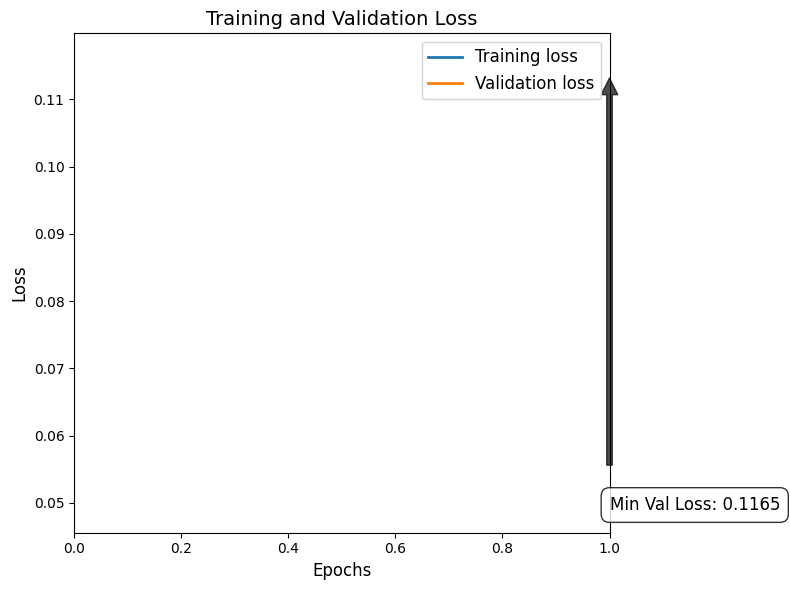

In [28]:
###############################################################################
# See some results
###############################################################################

# Plot training log
plot_training_log(training_log)

# Get a test batch
model.to('cpu')
model.eval()
inputs, masks, con,  stride_h, stride_w, downsampling_flag, start_level  = next(iter(dataloaders['train']))
# inputs = inputs.to(DEVICE)
# masks = masks.to(DEVICE)

# Predict
pred = model(inputs, stride_h, stride_w, downsampling_flag, start_level)

# Leave everything at cpu
inputs, masks, pred = inputs.cpu(), masks.cpu(), pred.cpu()

In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
# Ensure model is in evaluation mode
model.to('cpu')
model.eval()

msssim_fn = MS_SSIM(n_channels=3).to('cpu')

mse_values = []
psnr_values = []
msssim_values = []
l1_values = []

# Loop through the entire test set
for i, (inputs, ref, con, stride_h, stride_w, downsampling_flag, start_level) in enumerate(dataloaders['train']):
    # Move data to CPU
    inputs = inputs.cpu()
    con = con.cpu()
    ref = ref.cpu()  # Ensure reference is on CPU

    # Predict without gradients
    with torch.no_grad():
        pred = model(inputs, stride_h, stride_w, downsampling_flag, start_level)

    # Compute metrics on tensors BEFORE converting to numpy
    msk_tensor = ref[0].unsqueeze(0)  # Shape: [1, C, H, W]
    prd_tensor = pred[0].unsqueeze(0).detach()  # Shape: [1, C, H, W]

    # Compute Mean Squared Error
    mse = F.mse_loss(prd_tensor, msk_tensor).item()
    mse_values.append(mse)

    # Compute PSNR
    psnr = 10 * torch.log10(1 / F.mse_loss(prd_tensor, msk_tensor)).item()
    psnr_values.append(psnr)

    # Compute MS-SSIM
    msssim = msssim_fn(prd_tensor, msk_tensor).item()
    msssim_values.append(msssim)

    # Compute L1 loss
    l1 = F.l1_loss(prd_tensor, msk_tensor).item()
    l1_values.append(l1)

    # Convert to NumPy for visualization (AFTER computing metrics)
    im = to_npimage(inputs[0])
    msk = to_npimage(con[0])
    prd = to_npimage(pred[0].detach())
    ref = to_npimage(ref[0])

    pred_pil = Image.fromarray((prd * 255).astype(np.uint8))
    pred_pil.save(f"/teamspace/studios/this_studio/results/pred_{i:04d}.png")

    # Print per-image metrics
    print(f'MSE = {mse:.4f}, '
          f'PSNR = {psnr:.2f} dB, '
          f'MS-SSIM = {msssim:.4f}, '
          f'L1 = {l1:.4f}')

    # Visualize the image, ground truth mask, and prediction
    show_compare1(im, ref, prd, msk)

# Compute averages
avg_mse = np.mean(mse_values)
avg_psnr = np.mean(psnr_values)
avg_msssim = np.mean(msssim_values)
avg_l1 = np.mean(l1_values)

# Print summary
print('\n=== Average Metrics ===')
print(f'MSE:     {avg_mse:.4f}')
print(f'PSNR:    {avg_psnr:.2f} dB')
print(f'MS-SSIM: {avg_msssim:.4f}')
print(f'L1:      {avg_l1:.4f}')